# Imports

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import os, gc
from rdkit import Chem , rdBase
from rdkit.Chem import rdMolDescriptors, DataStructs, Descriptors, Draw
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from src import sascorer

rdBase.DisableLog('rdApp.error')

# Defining Generator

In [3]:
class Generator(nn.Module):
    def __init__(self, vocab_size, prop_dim, d_model=256, nhead=8, num_layers=4, max_len=128, dropout=0.1): 
        super().__init__()
        self.d_model = d_model
        self.token_embed = nn.Embedding(vocab_size, d_model)
        self.pos_embed = nn.Embedding(max_len, d_model)
        self.prop_embed = nn.Linear(prop_dim, d_model)
        self.dropout = nn.Dropout(dropout)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=512, batch_first=False, dropout=dropout  
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, src, props):
        src = torch.clamp(src, 0, self.token_embed.num_embeddings - 1)
        B, L = src.shape
        tok_emb = self.token_embed(src) * (self.d_model ** 0.5)
        pos = torch.arange(L, device=src.device).unsqueeze(0)
        pos_emb = self.pos_embed(pos)
        prop_emb = self.prop_embed(props).unsqueeze(1)
        
        x = tok_emb + pos_emb + prop_emb
        x = self.dropout(x) 
        x = x.transpose(0, 1)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(L).to(src.device)
        out = self.transformer(x, mask=tgt_mask)
        out = out.transpose(0, 1) 
        logits = self.fc_out(out)
        return logits

    def sample(self, props_to_use, token_maps, max_len=128, top_k=50):
        token_to_idx, _ = token_maps
        start_token_id = token_to_idx['<START>']
        stop_token_id  = token_to_idx['<END>']
        pad_token_id   = token_to_idx['<PAD>']
    
        batch_size = props_to_use.size(0)
        device = props_to_use.device
    
        generated_seqs = torch.full((batch_size, 1), start_token_id, dtype=torch.long, device=device)
        sum_log_probs = torch.zeros(batch_size, device=device)
    
        for t in range(max_len - 1):
    
            # Forward with grads ON → log_probs have grad_fn
            logits = self.forward(generated_seqs, props_to_use)
            last_logits = logits[:, -1, :]
    
            # Top-k filtering
            v, _ = torch.topk(last_logits, top_k, dim=-1)
            last_logits[last_logits < v[:, [-1]]] = -float("inf")
    
            probs = F.softmax(last_logits, dim=-1)
            log_probs = F.log_softmax(last_logits, dim=-1)
    
            # Non-differentiable sampling
            with torch.no_grad():
                next_token = torch.multinomial(probs, num_samples=1)
    
            # Log-prob of chosen token (differentiable)
            chosen_logprob = log_probs.gather(1, next_token).squeeze(1)
    
            not_finished = (generated_seqs[:, -1] != stop_token_id).float()
            sum_log_probs += chosen_logprob * not_finished
    
            generated_seqs = torch.cat([generated_seqs, next_token], dim=1)
    
            generated_seqs = generated_seqs.detach()
    
            if not_finished.sum() == 0:
                break
    
        with torch.no_grad():
            B, L = generated_seqs.shape
            if L < max_len:
                pads = torch.full((B, max_len - L), pad_token_id, dtype=torch.long, device=device)
                generated_seqs = torch.cat([generated_seqs, pads], dim=1)
    
        return generated_seqs, sum_log_probs

# Helper functions

In [4]:
def get_token_maps():
    token_to_idx = {
        "#": 2, "%": 3, "(": 4, ")": 5, "+": 6, "-": 7, ".": 8, "/": 9, "0": 10, "1": 11, "2": 12, "3": 13,
        "4": 14, "5": 15, "6": 16, "7": 17, "8": 18, "9": 19, "=": 20, "@": 21, "A": 22, "B": 23, "C": 24,
        "D": 25, "E": 26, "F": 27, "G": 28, "H": 29, "I": 30, "K": 31, "L": 32, "M": 33, "N": 34, "O": 35,
        "P": 36, "R": 37, "S": 38, "T": 39, "U": 40, "V": 41, "W": 42, "X": 43, "Y": 44, "Z": 45, "[": 46,
        "\\": 47, "]": 48, "a": 49, "b": 50, "c": 51, "d": 52, "e": 53, "f": 54, "g": 55, "h": 56, "i": 57,
        "k": 58, "l": 59, "m": 60, "n": 61, "o": 62, "p": 63, "r": 64, "s": 65, "t": 66, "u": 67,
        "y": 68, "<PAD>": 0, "<START>": 1, "<END>": 69
    }
    idx_to_token = {v: k for k, v in token_to_idx.items()}
    return token_to_idx, idx_to_token

token_to_idx, idx_to_token = get_token_maps()


def decode_smiles(tensor, idx_to_token):
    smiles_list = []
    for row in tensor:
        smi = ""
        for idx in row:
            idx = idx.item()
            if idx == 1: continue
            if idx == 69: break
            if idx == 0: break
            smi += idx_to_token.get(idx, '?')
        smiles_list.append(smi)
    return smiles_list

def get_props(mol):
    try:
        qed = Descriptors.qed(mol)
        sas = sascorer.calculateScore(mol)
        logp = Descriptors.MolLogP(mol)
        tpsa = Descriptors.TPSA(mol)
        mw = Descriptors.MolWt(mol)
        return [qed, sas, logp, tpsa, mw]
    except:
        return [0.0]*5

def compute_properties(smiles_list):
    props = []
    valids = []
    mols = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            mols.append(mol)
            valids.append(1)
            props.append(get_props(mol))
        else:
            mols.append(None)
            valids.append(0)
            props.append([0]*5)
    return np.array(props), np.array(valids), mols


def sample_generator(generator, props, token_maps, max_len=128):
    generator.eval()
    with torch.no_grad():
        seqs, _ = generator.sample(props, token_maps, max_len=max_len)
    return seqs.cpu()


GEN_CHECKPOINT_PATH = "../results/models_5l/generator_RL_step_5000.pt" 

VOCAB_SIZE = 70 
PROP_DIM = 5
D_MODEL = 256
N_HEAD = 8
NUM_LAYERS = 4
MAX_LEN = 128
DROPOUT = 0.1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

generator = Generator(
    vocab_size=VOCAB_SIZE, prop_dim=PROP_DIM, d_model=D_MODEL, nhead=N_HEAD, 
    num_layers=NUM_LAYERS, max_len=MAX_LEN, dropout=DROPOUT
).to(device)

gen_checkpoint = torch.load(GEN_CHECKPOINT_PATH, map_location=device, weights_only=True)
generator.load_state_dict(gen_checkpoint['model_state_dict'])
generator.eval() 
print("Loaded trained generator.")

Using device: cuda


c:\Users\dhanu\Desktop\bio-info data\venv\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Loaded trained generator.


In [42]:

train_df = pd.read_csv("../data/processed_5l/train_properties.csv")
val_df = pd.read_csv("../data/processed_5l/val_properties.csv")
test_df = pd.read_csv("../data/processed_5l/test_properties.csv")

if "canonical" in train_df.columns:
    train_smiles = set(train_df["canonical"].astype(str).tolist())
else:
    train_smiles = set(train_df["smiles"].astype(str).tolist())

print(f"Loaded {len(train_smiles)} training SMILES for novelty comparison.")


Loaded 278937 training SMILES for novelty comparison.


# Uncoditional / weak noise Conditional Testing

In [37]:
# SAMPLE MOLECULES

N_SAMPLES = 2000
BATCH = 32
# zeros = torch.zeros((BATCH, 5)).to(device)   # remove conditioning
all_smiles = []

for _ in tqdm(range(N_SAMPLES // BATCH), desc="Sampling"):
    rand_props = torch.rand((BATCH, 5)).to(device) * 0.1
    seqs = sample_generator(generator, rand_props, (token_to_idx, idx_to_token), max_len=MAX_LEN)
    smiles = decode_smiles(seqs, idx_to_token)
    all_smiles.extend(smiles)

print("Generated", len(all_smiles), "SMILES.")

Sampling: 100%|██████████| 62/62 [00:44<00:00,  1.39it/s]

Generated 1984 SMILES.


In [38]:
# Compute validity, uniqueness, novelty
props_np, valid_arr, mols = compute_properties(all_smiles)

validity = valid_arr.mean()
unique_smiles = len(set(all_smiles))
uniqueness = unique_smiles / len(all_smiles)

novel_smiles = [s for s in all_smiles if s not in train_smiles]
novelty = len(novel_smiles) / len(all_smiles)

print("\n=== QUALITY METRICS ===")
print(f"Validity:   {validity*100:.2f}%")
print(f"Uniqueness: {uniqueness*100:.2f}%")
print(f"Novelty:    {novelty*100:.2f}%")


=== QUALITY METRICS ===
Validity:   96.12%
Uniqueness: 86.09%
Novelty:    87.60%


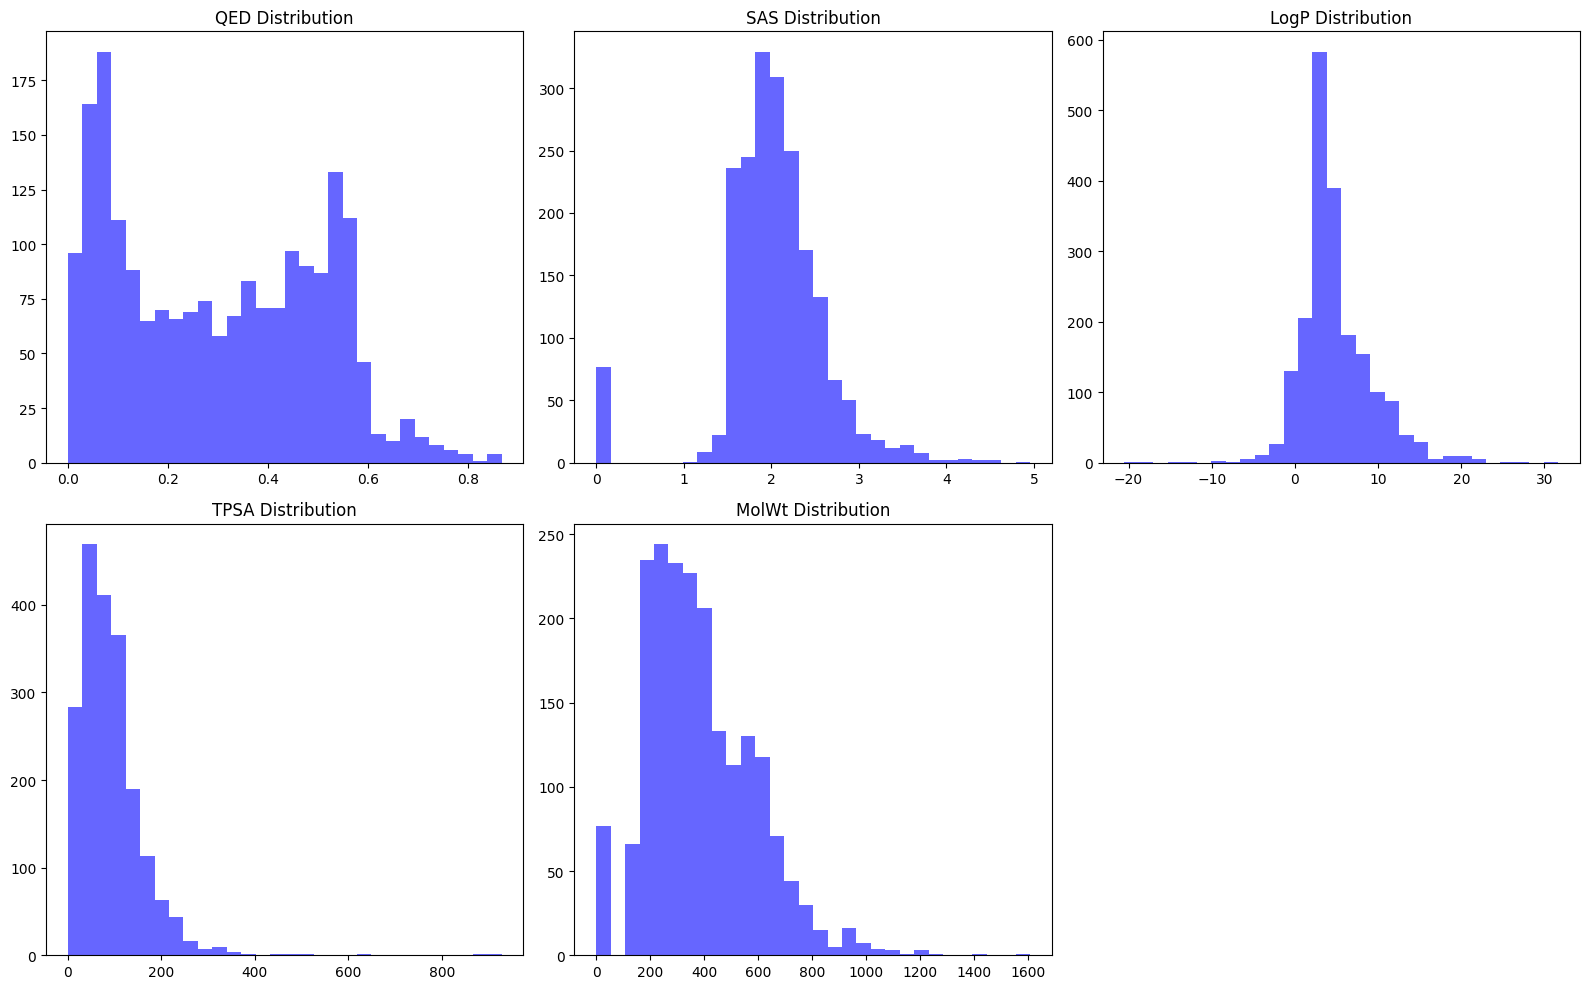

In [39]:
# Plot property distributions
prop_names = ["QED", "SAS", "LogP", "TPSA", "MolWt"]

plt.figure(figsize=(16,10))
for i in range(5):
    plt.subplot(2,3,i+1)
    plt.hist(props_np[:,i], bins=30, color="blue", alpha=0.6)
    plt.title(f"{prop_names[i]} Distribution")
plt.tight_layout()
plt.show()


In [40]:
# Diversity score (internal pairwise Tanimoto)
def tanimoto_diversity(mols, sample_size=200):
    vecs = []
    for m in mols[:sample_size]:
        if m:
            fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(m, 2, nBits=2048)
            vecs.append(fp)

    if len(vecs) < 2:
        return 0.0

    scores = []
    for i in range(len(vecs)):
        for j in range(i+1, len(vecs)):
            sim = DataStructs.TanimotoSimilarity(vecs[i], vecs[j])
            scores.append(1 - sim)
    return np.mean(scores)

div_score = tanimoto_diversity(mols, sample_size=200)
print(f"\nDiversity (1 - Tanimoto): {div_score:.4f}")


Diversity (1 - Tanimoto): 0.6187


[15:23:32] DEPRECATION WARNING: please use MorganGenerator
[15:23:32] DEPRECATION WARNING: please use MorganGenerator
[15:23:32] DEPRECATION WARNING: please use MorganGenerator
[15:23:32] DEPRECATION WARNING: please use MorganGenerator
[15:23:32] DEPRECATION WARNING: please use MorganGenerator
[15:23:32] DEPRECATION WARNING: please use MorganGenerator
[15:23:32] DEPRECATION WARNING: please use MorganGenerator
[15:23:32] DEPRECATION WARNING: please use MorganGenerator
[15:23:32] DEPRECATION WARNING: please use MorganGenerator
[15:23:32] DEPRECATION WARNING: please use MorganGenerator
[15:23:32] DEPRECATION WARNING: please use MorganGenerator
[15:23:32] DEPRECATION WARNING: please use MorganGenerator
[15:23:32] DEPRECATION WARNING: please use MorganGenerator
[15:23:32] DEPRECATION WARNING: please use MorganGenerator
[15:23:32] DEPRECATION WARNING: please use MorganGenerator
[15:23:32] DEPRECATION WARNING: please use MorganGenerator
[15:23:32] DEPRECATION WARNING: please use MorganGenerat

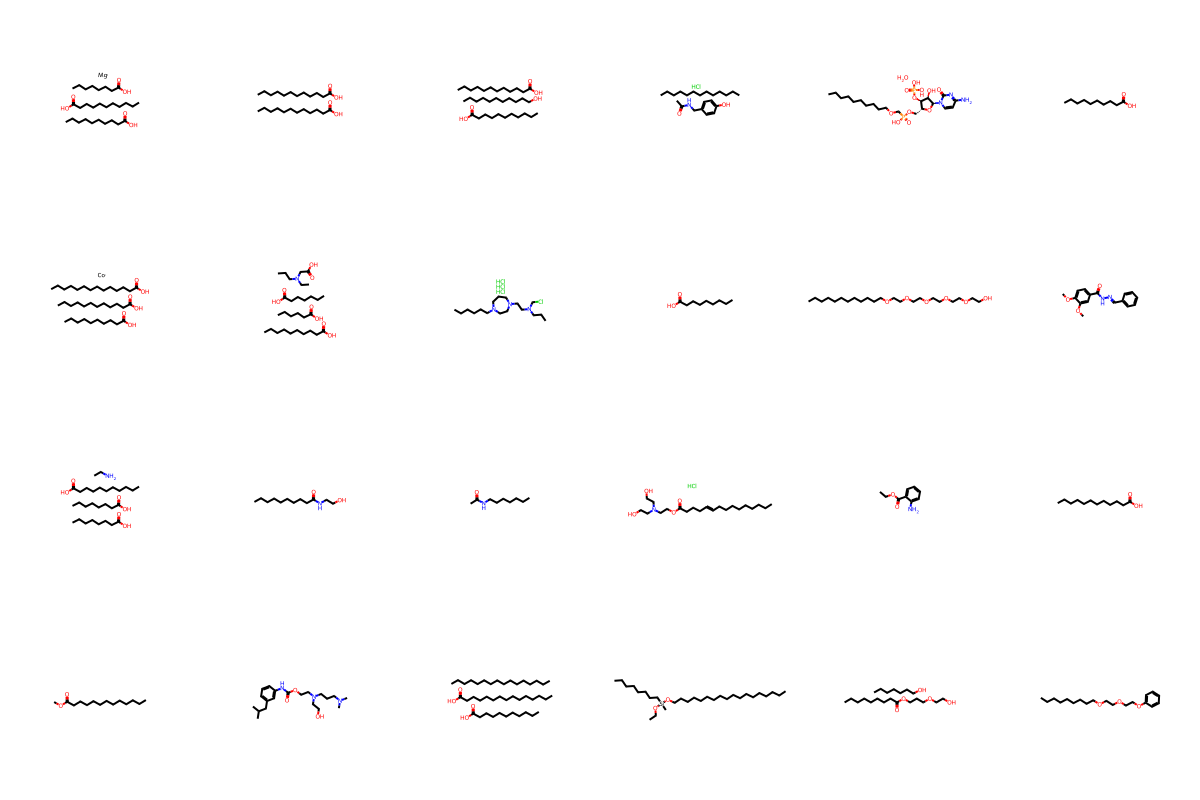


Evaluation Complete.


In [41]:

sample_mols = [m for m in mols if m is not None]
if len(sample_mols) > 24:
    sample_mols = random.sample(sample_mols, 24)

img = Draw.MolsToGridImage(sample_mols, molsPerRow=6, subImgSize=(200,200))
display(img)

print("\nEvaluation Complete.")

# Conditional Metrics Testing

taking Validation dataset propeties as input

In [43]:
# SAMPLE MOLECULES

N_SAMPLES = 2000
BATCH = 32

all_smiles = []

for _ in tqdm(range(N_SAMPLES // BATCH), desc="Sampling"):
    props = torch.tensor(
        val_df.sample(BATCH)[['QED','SAS','LogP','TPSA','MolWt']].values,
        dtype=torch.float32
    ).to(device)

    seqs = sample_generator(generator, props, (token_to_idx, idx_to_token), max_len=MAX_LEN)
    smiles = decode_smiles(seqs, idx_to_token)
    all_smiles.extend(smiles)

print("Generated", len(all_smiles), "SMILES.")

Sampling: 100%|██████████| 62/62 [00:45<00:00,  1.37it/s]

Generated 1984 SMILES.


In [44]:
# Compute validity, uniqueness, novelty
props_np, valid_arr, mols = compute_properties(all_smiles)

validity = valid_arr.mean()
unique_smiles = len(set(all_smiles))
uniqueness = unique_smiles / len(all_smiles)

novel_smiles = [s for s in all_smiles if s not in train_smiles]
novelty = len(novel_smiles) / len(all_smiles)

print("\n=== QUALITY METRICS ===")
print(f"Validity:   {validity*100:.2f}%")
print(f"Uniqueness: {uniqueness*100:.2f}%")
print(f"Novelty:    {novelty*100:.2f}%")

[15:29:13] Unusual charge on atom 26 number of radical electrons set to zero
[15:29:13] Unusual charge on atom 26 number of radical electrons set to zero
[15:29:13] Unusual charge on atom 22 number of radical electrons set to zero
[15:29:13] Unusual charge on atom 22 number of radical electrons set to zero
[15:29:14] WARNING: not removing hydrogen atom without neighbors
[15:29:14] WARNING: not removing hydrogen atom without neighbors
[15:29:14] WARNING: not removing hydrogen atom without neighbors
[15:29:14] WARNING: not removing hydrogen atom without neighbors
[15:29:14] WARNING: not removing hydrogen atom without neighbors
[15:29:14] WARNING: not removing hydrogen atom without neighbors
[15:29:14] WARNING: not removing hydrogen atom without neighbors
[15:29:14] WARNING: not removing hydrogen atom without neighbors
[15:29:14] WARNING: not removing hydrogen atom without neighbors
[15:29:14] WARNING: not removing hydrogen atom without neighbors



=== QUALITY METRICS ===
Validity:   80.14%
Uniqueness: 99.95%
Novelty:    98.59%


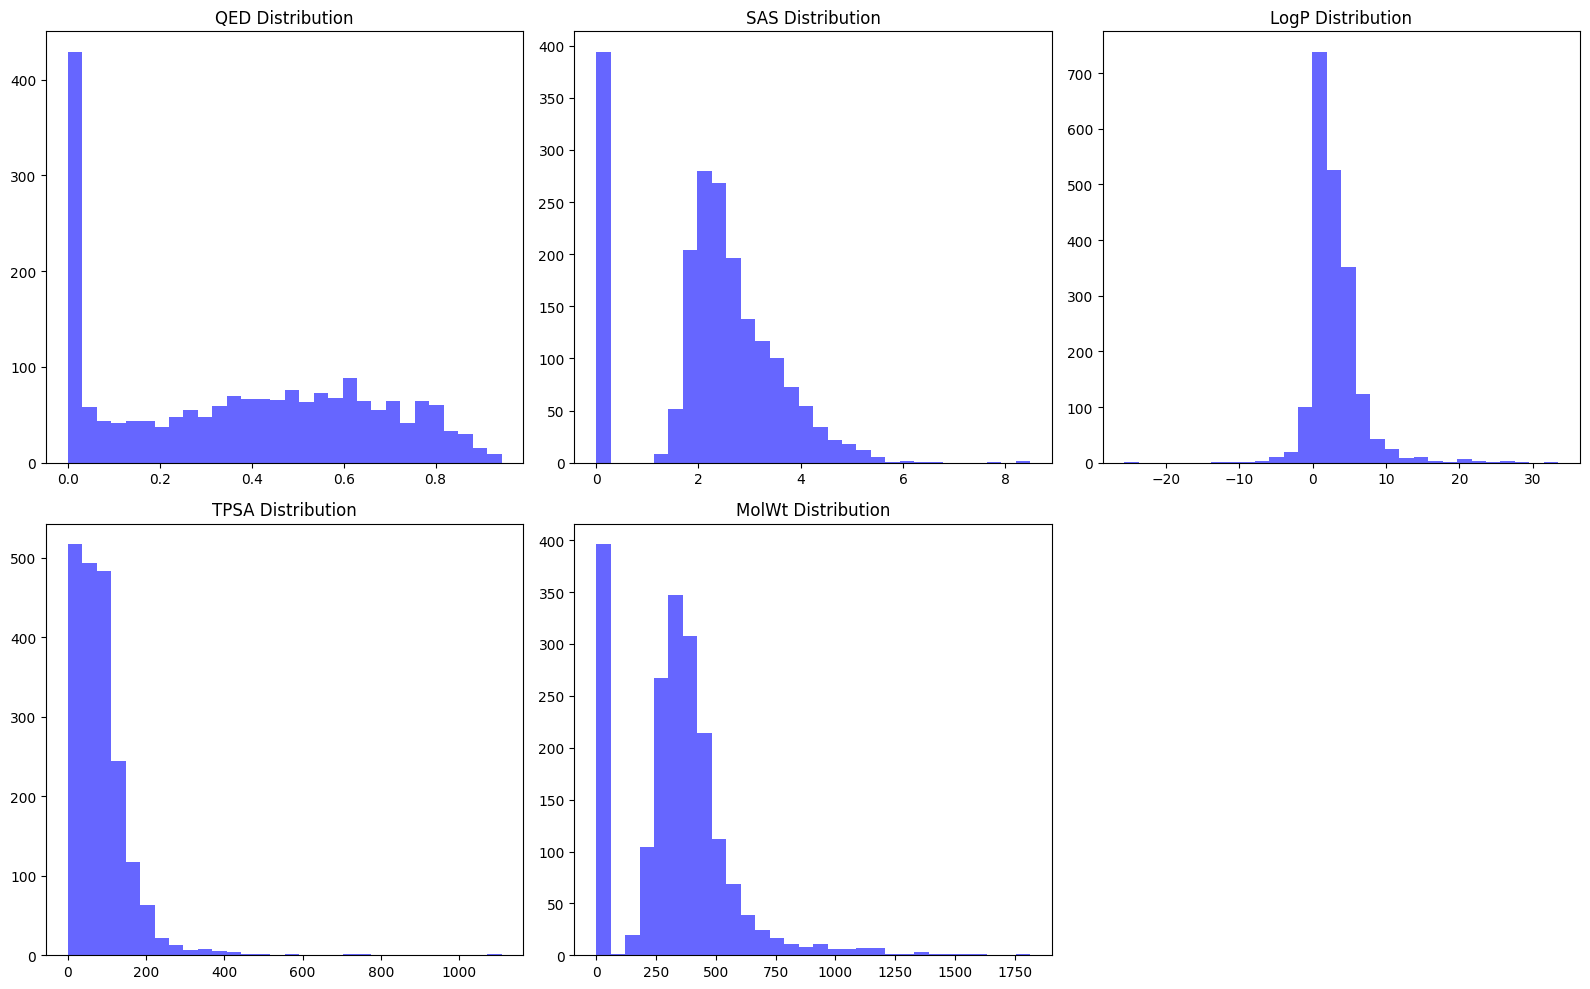

In [45]:
# Plot property distributions
prop_names = ["QED", "SAS", "LogP", "TPSA", "MolWt"]

plt.figure(figsize=(16,10))
for i in range(5):
    plt.subplot(2,3,i+1)
    plt.hist(props_np[:,i], bins=30, color="blue", alpha=0.6)
    plt.title(f"{prop_names[i]} Distribution")
plt.tight_layout()
plt.show()


In [46]:
# Diversity score (internal pairwise Tanimoto)
def tanimoto_diversity(mols, sample_size=200):
    vecs = []
    for m in mols[:sample_size]:
        if m:
            fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(m, 2, nBits=2048)
            vecs.append(fp)

    if len(vecs) < 2:
        return 0.0

    scores = []
    for i in range(len(vecs)):
        for j in range(i+1, len(vecs)):
            sim = DataStructs.TanimotoSimilarity(vecs[i], vecs[j])
            scores.append(1 - sim)
    return np.mean(scores)

div_score = tanimoto_diversity(mols, sample_size=200)
print(f"\nDiversity (1 - Tanimoto): {div_score:.4f}")


Diversity (1 - Tanimoto): 0.8427


[15:30:14] DEPRECATION WARNING: please use MorganGenerator
[15:30:14] DEPRECATION WARNING: please use MorganGenerator
[15:30:14] DEPRECATION WARNING: please use MorganGenerator
[15:30:14] DEPRECATION WARNING: please use MorganGenerator
[15:30:14] DEPRECATION WARNING: please use MorganGenerator
[15:30:14] DEPRECATION WARNING: please use MorganGenerator
[15:30:14] DEPRECATION WARNING: please use MorganGenerator
[15:30:14] DEPRECATION WARNING: please use MorganGenerator
[15:30:14] DEPRECATION WARNING: please use MorganGenerator
[15:30:14] DEPRECATION WARNING: please use MorganGenerator
[15:30:14] DEPRECATION WARNING: please use MorganGenerator
[15:30:14] DEPRECATION WARNING: please use MorganGenerator
[15:30:14] DEPRECATION WARNING: please use MorganGenerator
[15:30:14] DEPRECATION WARNING: please use MorganGenerator
[15:30:14] DEPRECATION WARNING: please use MorganGenerator
[15:30:14] DEPRECATION WARNING: please use MorganGenerator
[15:30:14] DEPRECATION WARNING: please use MorganGenerat

taking Training dataset properies as input

In [48]:
# SAMPLE MOLECULES

N_SAMPLES = 2000
BATCH = 32

all_smiles = []

for _ in tqdm(range(N_SAMPLES // BATCH), desc="Sampling"):
    props = torch.tensor(
        train_df.sample(BATCH)[['QED','SAS','LogP','TPSA','MolWt']].values,
        dtype=torch.float32
    ).to(device)

    seqs = sample_generator(generator, props, (token_to_idx, idx_to_token), max_len=MAX_LEN)
    smiles = decode_smiles(seqs, idx_to_token)
    all_smiles.extend(smiles)

print("Generated", len(all_smiles), "SMILES.")

Sampling: 100%|██████████| 62/62 [00:46<00:00,  1.34it/s]

Generated 1984 SMILES.


In [49]:
# Compute validity, uniqueness, novelty
props_np, valid_arr, mols = compute_properties(all_smiles)

validity = valid_arr.mean()
unique_smiles = len(set(all_smiles))
uniqueness = unique_smiles / len(all_smiles)

novel_smiles = [s for s in all_smiles if s not in train_smiles]
novelty = len(novel_smiles) / len(all_smiles)

print("\n=== QUALITY METRICS ===")
print(f"Validity:   {validity*100:.2f}%")
print(f"Uniqueness: {uniqueness*100:.2f}%")
print(f"Novelty:    {novelty*100:.2f}%")


=== QUALITY METRICS ===
Validity:   86.14%
Uniqueness: 99.50%
Novelty:    95.46%


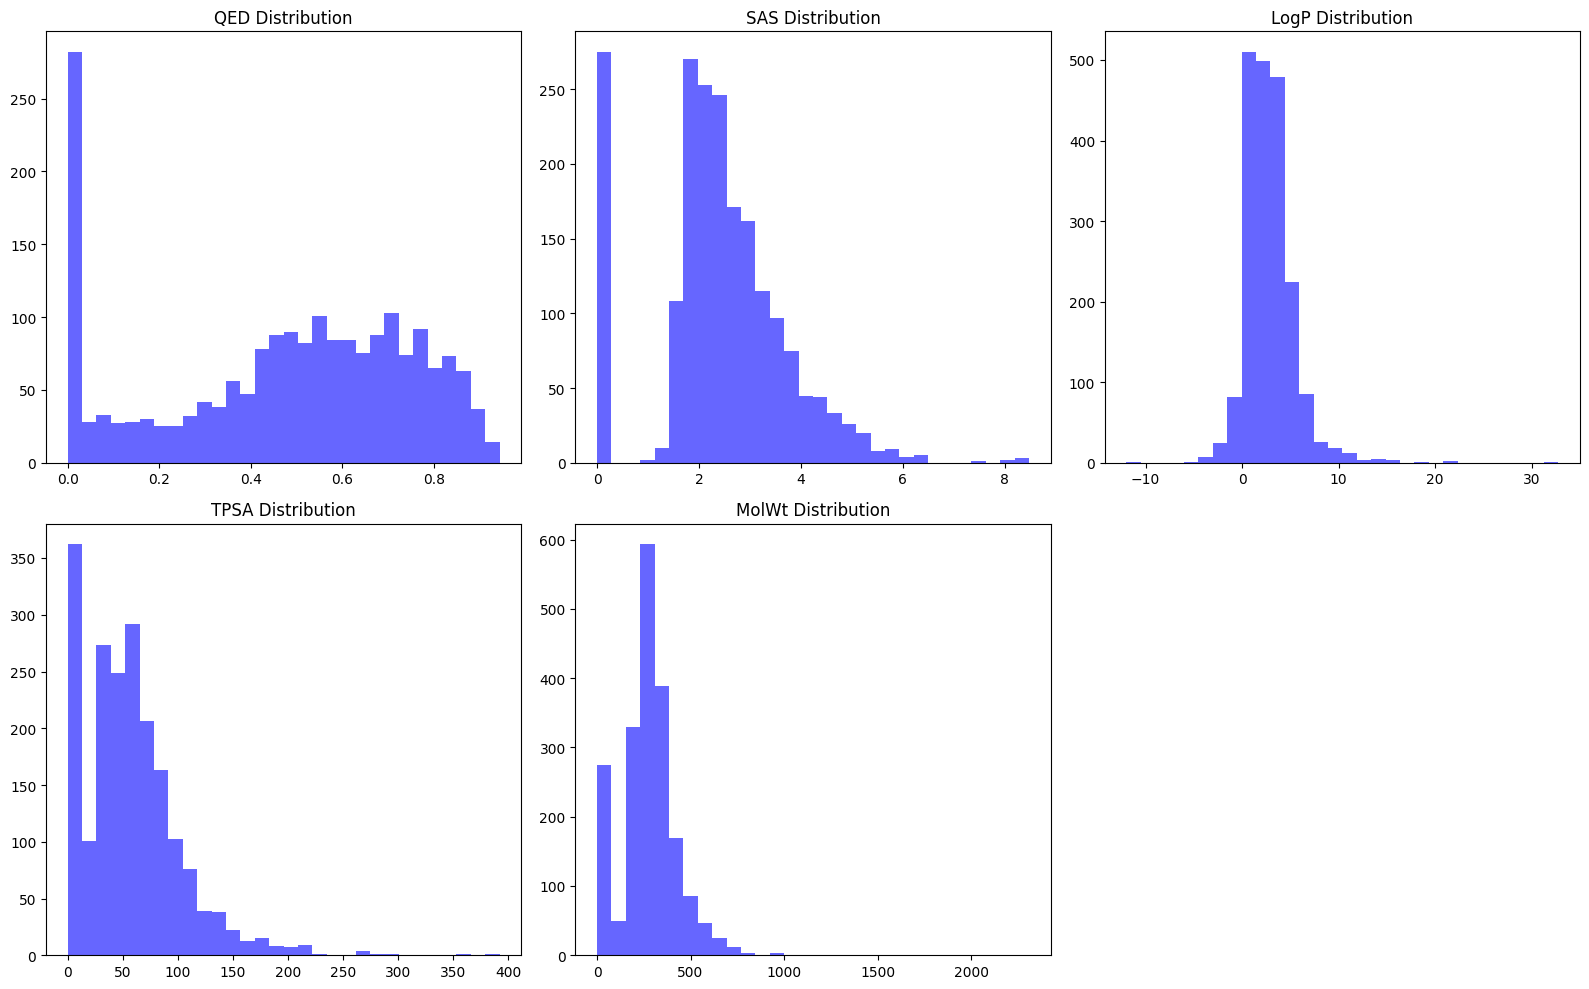

In [50]:
# Plot property distributions
prop_names = ["QED", "SAS", "LogP", "TPSA", "MolWt"]

plt.figure(figsize=(16,10))
for i in range(5):
    plt.subplot(2,3,i+1)
    plt.hist(props_np[:,i], bins=30, color="blue", alpha=0.6)
    plt.title(f"{prop_names[i]} Distribution")
plt.tight_layout()
plt.show()

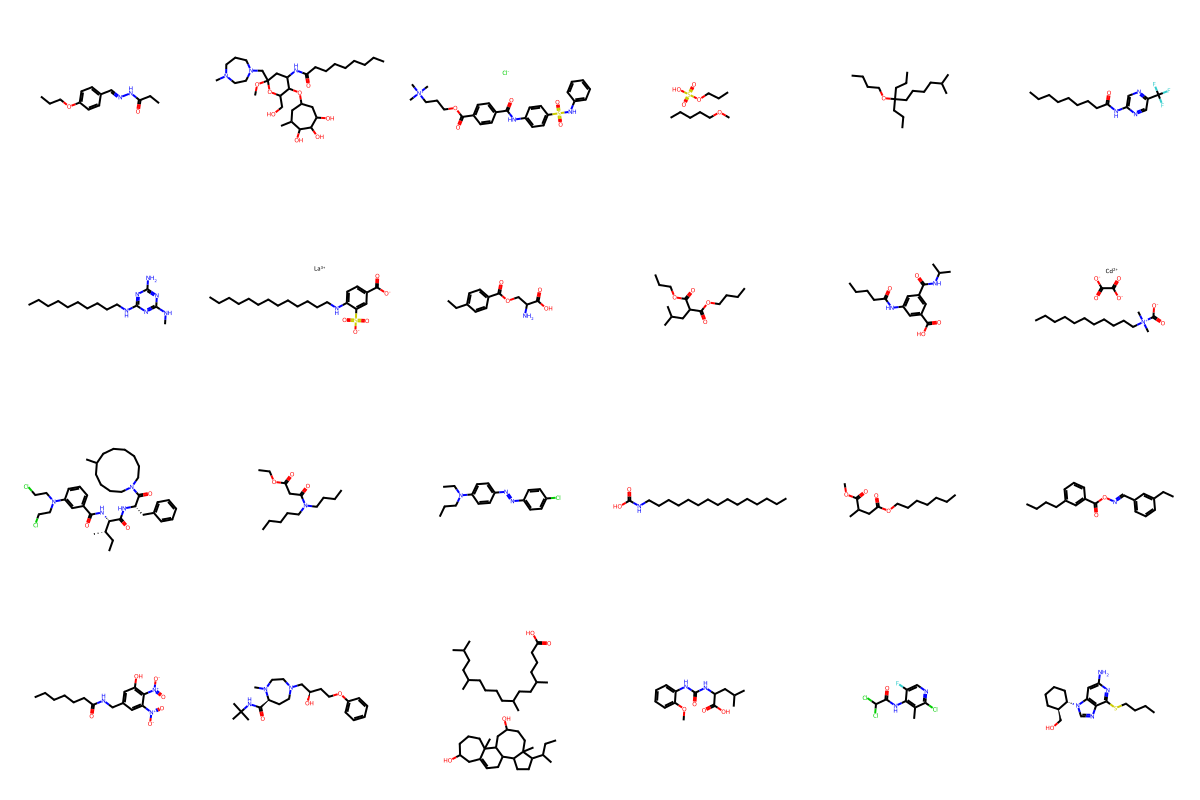


Evaluation Complete.


In [51]:

sample_mols = [m for m in mols if m is not None]
if len(sample_mols) > 24:
    sample_mols = random.sample(sample_mols, 24)

img = Draw.MolsToGridImage(sample_mols, molsPerRow=6, subImgSize=(200,200))
display(img)

print("\nEvaluation Complete.")

# Conditional Molecule Props Testing

In [17]:
target_props = torch.tensor([[0.8, 2.5, 3.0, 120.0, 300.0]])  

In [18]:
import json
import torch
import numpy as np

STATS_PATH = "../data/processed_5l/property_stats.json"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

prop_cols = ["QED", "SAS", "LogP", "TPSA", "MolWt"]

with open(STATS_PATH, 'r') as f:
    loaded_stats = json.load(f)

prop_stats = {
    'min': torch.tensor([loaded_stats['min'][c] for c in prop_cols], dtype=torch.float32).to(device),
    'max': torch.tensor([loaded_stats['max'][c] for c in prop_cols], dtype=torch.float32).to(device)
}


prop_stats['range'] = (prop_stats['max'] - prop_stats['min']) + 1e-8

print("=== Loaded Normalization Stats ===")
print("Min:", prop_stats['min'].cpu().numpy())
print("Max:", prop_stats['max'].cpu().numpy())
print("Range:", prop_stats['range'].cpu().numpy())

=== Loaded Normalization Stats ===
Min: [ 3.9431723e-03  1.0000000e+00 -8.7627800e+01  0.0000000e+00
  1.0080000e+00]
Max: [9.4825125e-01 1.0000000e+01 5.9808720e+01 4.2015000e+03 1.8838697e+04]
Range: [9.4430810e-01 9.0000000e+00 1.4743652e+02 4.2015000e+03 1.8837689e+04]


In [52]:
# Define QUERY in RAW FORM
query_raw = torch.tensor([[0.8, 2.5, 3.0, 120.0, 300.0]], dtype=torch.float32).to(device)
query_norm = (query_raw - prop_stats['min']) / prop_stats['range']
query_norm = torch.clamp(query_norm, 0.0, 1.0)

print("\n=== QUERY ===")
print("Raw Query: ", query_raw.cpu().numpy())
print("Normalized Query:", query_norm.cpu().numpy())



=== QUERY ===
Raw Query:  [[  0.8   2.5   3.  120.  300. ]]
Normalized Query: [[0.8430054  0.16666667 0.6146903  0.02856123 0.01587201]]


In [ ]:
N_SAMPLES = 50
smiles_list = []

for _ in tqdm(range(N_SAMPLES), desc="Sampling"):
    seqs = sample_generator(generator, query_norm, (token_to_idx, idx_to_token), max_len=MAX_LEN)
    smiles = decode_smiles(seqs, idx_to_token)
    smiles_list.extend(smiles)

print(f"Generated {len(smiles_list)} SMILES.")


Sampling: 100%|██████████| 50/50 [00:07<00:00,  6.32it/s]

Generated 50 SMILES.


In [58]:
actual_props, valid_arr, mols = compute_properties(smiles_list)  # RAW outputs

# Normalize for comparison
actual_props_norm = (actual_props - prop_stats['min'].cpu().numpy()) / prop_stats['range'].cpu().numpy()
actual_props_norm = np.clip(actual_props_norm, 0.0, 1.0)

print("\nSample of normalized props:", actual_props_norm[:3])
print("Validity:", valid_arr.mean())


Sample of normalized props: [[0.89355649 0.14092252 0.61440054 0.01258836 0.0139946 ]
 [0.66532491 0.1259115  0.62507442 0.00483399 0.0186259 ]
 [0.66509179 0.14900134 0.63652545 0.00219683 0.01751229]]
Validity: 0.94


In [ ]:
mse = ((actual_props_norm - query_norm.cpu().numpy())**2).mean(axis=1)

TOP_K = 10
sorted_indices = np.argsort(mse)
top_k_indices = sorted_indices[:TOP_K]

print(f"\n=== 🔝 TOP {TOP_K} MATCHING MOLECULES ===")
top_smiles = []
top_props_raw = []

for idx in top_k_indices:
    print(f"\nRank {list(top_k_indices).index(idx)+1} | MSE = {mse[idx]:.4f}")
    print("SMILES:", smiles_list[idx])
    print("RAW PROPS:", actual_props[idx])
    print("NORM PROPS:", actual_props_norm[idx])
    top_smiles.append(smiles_list[idx])
    top_props_raw.append(actual_props[idx])


=== 🔝 TOP 10 MATCHING MOLECULES ===

Rank 1 | MSE = 0.0001
SMILES: COC(=O)c1ccccc1NC1CCN(C(=O)c2ccccc2)C1.Cl.Cl
RAW PROPS: [  0.80079177   2.46156333   3.6434      58.64       397.302     ]
NORM PROPS: [0.84384386 0.16239593 0.61905421 0.01395692 0.02103729]

Rank 2 | MSE = 0.0001
SMILES: CNC(=O)Oc1ccc(C=C(C#N)C#N)cc1
RAW PROPS: [  0.78072685   2.4780057    1.83536     85.91       227.223     ]
NORM PROPS: [0.82259559 0.16422286 0.60679103 0.02044746 0.01200864]

Rank 3 | MSE = 0.0002
SMILES: CC(CO)(COc1ccccc1)CN(C)C
RAW PROPS: [  0.79527664   2.72280364   1.6256      32.7        223.316     ]
NORM PROPS: [0.83800347 0.19142263 0.60536832 0.00778293 0.01180123]

Rank 4 | MSE = 0.0003
SMILES: CCCCc1nc(N)nc(NC(C)C)n1
RAW PROPS: [  0.77016239   2.36779728   1.6167      76.72       209.297     ]
NORM PROPS: [0.81140807 0.15197748 0.60530795 0.01826015 0.01105704]

Rank 5 | MSE = 0.0003
SMILES: CCC(=O)N[C@@H](Cc1ccccc1)C(=O)NC(C)=O
RAW PROPS: [  0.82332518   2.30071681   0.7866      75.27 

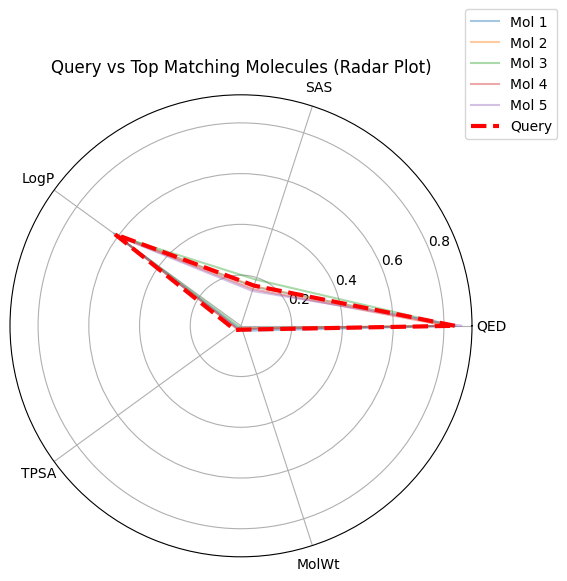

In [62]:
import matplotlib.pyplot as plt
import numpy as np

prop_names = ["QED", "SAS", "LogP", "TPSA", "MolWt"]

num_plots = min(5, len(top_k_indices)) 
angles = np.linspace(0, 2*np.pi, len(prop_names), endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(12, 6))

for idx in top_k_indices[:num_plots]:
    vals = actual_props_norm[idx].tolist() 
    vals += vals[:1]  
    plt.polar(angles, vals, alpha=0.4)

q = query_norm.cpu().numpy()[0].tolist()
q += q[:1]
plt.polar(angles, q, linewidth=3, linestyle='--', label="QUERY", color='red')

plt.xticks(angles[:-1], prop_names)
plt.title("Query vs Top Matching Molecules (Radar Plot)")
plt.legend([f"Mol {i+1}" for i in range(num_plots)] + ["Query"], loc='upper right', bbox_to_anchor=(1.2, 1.2))
plt.show()



Valid molecules for visualization: 10 / 10


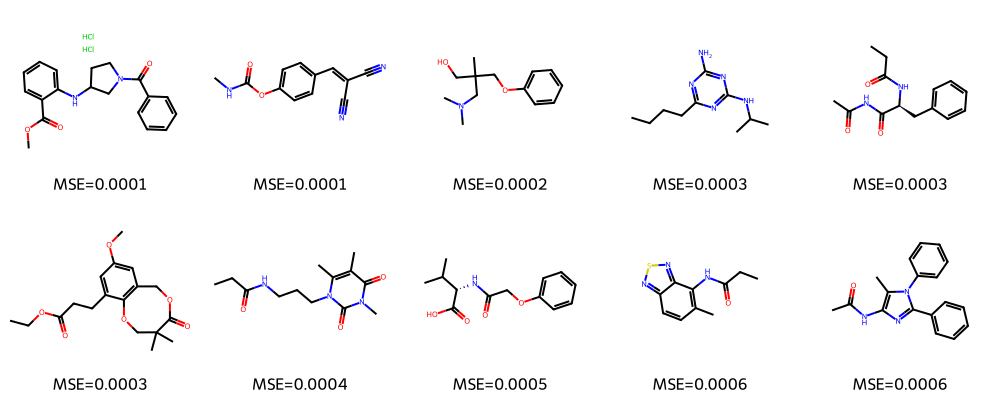

In [60]:
from rdkit.Chem import Draw

valid_top_mols = []
for s in top_smiles:
    mol = Chem.MolFromSmiles(s)
    if mol:
        valid_top_mols.append(mol)

# Pick only valid molecules
print(f"\nValid molecules for visualization: {len(valid_top_mols)} / {TOP_K}")

# Draw grid image
if len(valid_top_mols) > 0:
    img = Draw.MolsToGridImage(valid_top_mols, molsPerRow=5, subImgSize=(200,200),
                               legends=[f"MSE={mse[i]:.4f}" for i in top_k_indices[:len(valid_top_mols)]])
    display(img)
else:
    print("No valid molecules were generated for visualization.")

In [61]:
cos_sim = np.array([ np.dot(a, query_norm.cpu().numpy()[0]) / (np.linalg.norm(a) * np.linalg.norm(query_norm.cpu().numpy()[0]) + 1e-8) for a in actual_props_norm ])

print("\n---- OVERALL MATCH STATS ----")
print(f"Mean MSE: {mse.mean():.4f}")
print(f"Median MSE: {np.median(mse):.4f}")
print(f"Mean Cosine Similarity: {cos_sim.mean():.4f}")
print(f"Validity: {valid_arr.mean()*100:.2f}%")



---- OVERALL MATCH STATS ----
Mean MSE: 0.0135
Median MSE: 0.0020
Mean Cosine Similarity: 0.9686
Validity: 94.00%


# Conditional Molecule Individual Testing

In [24]:
def generate_and_evaluate_one(prop_query_raw, generator, token_maps, max_len=128):
    # Convert input to tensor
    if not torch.is_tensor(prop_query_raw):
        prop_query_raw = torch.tensor([prop_query_raw], dtype=torch.float32).to(device)
    else:
        prop_query_raw = prop_query_raw.to(device)

    # Normalize 
    prop_query_norm = (prop_query_raw - prop_stats['min']) / prop_stats['range']
    prop_query_norm = torch.clamp(prop_query_norm, 0.0, 1.0)

    # Generate molecule
    generator.eval()
    with torch.no_grad():
        seqs = sample_generator(generator, prop_query_norm, token_maps, max_len=max_len)
    smiles = decode_smiles(seqs, token_maps[1])[0]  # only one molecule

    # Compute RDKit properties
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        props_raw = np.array(get_props(mol))
        valid = True
    else:
        props_raw = np.zeros(5)
        valid = False

    return smiles, props_raw, valid


In [25]:
test_raw = [0.8, 2.5, 3.0, 120, 300]
smiles, props_raw, valid = generate_and_evaluate_one(test_raw, generator, (token_to_idx, idx_to_token))
print("SMILES:", smiles)
print("Valid:", valid)
print("Generated Properties (RAW):", props_raw)


SMILES: CC[C@H](C)C(=O)N[C@@H](Cc1ccccc1)C(=O)NC
Valid: True
Generated Properties (RAW): [  0.81608459   2.494005     1.506       58.2        262.353     ]


In [26]:
print("Target Query:", test_raw)
print("Absolute Error:", np.abs(props_raw - np.array(test_raw)))

Target Query: [0.8, 2.5, 3.0, 120, 300]
Absolute Error: [1.60845918e-02 5.99499964e-03 1.49400000e+00 6.18000000e+01
 3.76470000e+01]


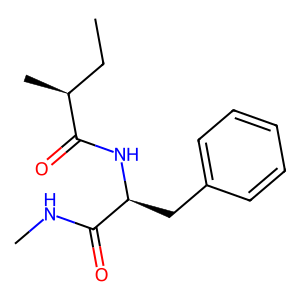

In [27]:
from rdkit.Chem import Draw
from rdkit import Chem

if valid and smiles:
    mol = Chem.MolFromSmiles(smiles)
    img = Draw.MolsToGridImage([mol], molsPerRow=1, subImgSize=(300, 300))
    display(img)
else:
    print("Molecule was invalid — cannot visualize.")


In [28]:
norm = torch.tensor([0.7405557018093497,0.12368295660876186,0.6018468151173257,0.009953588004260494,0.009460343038888964]).to(device)

real_values = norm * prop_stats['range'] + prop_stats['min']
real_list = real_values.cpu().numpy().tolist()
print(real_list)


[0.7032558917999268, 2.1131465435028076, 1.1063995361328125, 41.81999969482422, 179.218994140625]


In [29]:
smiles, props_raw, valid = generate_and_evaluate_one(real_list, generator, (token_to_idx, idx_to_token))
print("SMILES:", smiles)
print("Valid:", valid)
print("Generated Properties (RAW):", props_raw)

SMILES: CCOc1ccc(C(C)C)cc1CC(=O)OCC
Valid: True
Generated Properties (RAW): [  0.72652291   1.86614415   3.3143      35.53       250.338     ]
